In [1]:
import numpy as np
import os, sys
import importlib
from tqdm.notebook import tqdm, trange
import pandas as pd
import json
import itertools
from IPython.display import display, HTML, clear_output
import matplotlib.pyplot as plt
%matplotlib inline

from FewShotTestHandler import FewShotTestHandler, optimize_hyperparameters, find_hyperparameters, dataframe_format
from dataset import DatasetHandler
from similarity_metrics import Similarity
from plotting_utils import plot

ENV = os.environ["CONDA_DEFAULT_ENV"]
pd.options.display.max_rows = 200

/home/rob/vlm_benchmark/FewShotTestHandler.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
!pip install scikit-optimize
import skopt
import skopt.plots

### Settings

In [3]:
# VLM Params - vlm.____ keys are passed into VLM constructor
if ENV == "VLM_CLIP":
    from CLIP.CLIPVLM import ClipVLM as VLM
    vlm = VLM(num_frames=10)
elif ENV == "VLM_MILES":
    from MILES.wrapper import MILES_SimilarityVLM as VLM
    vlm = VLM()
elif ENV == "videoclip":
    from video_clip.video_clip import VideoClipVLM as VLM
    vlm = VLM(num_seconds=4, sample_strat="spread", use_cuda=True)
elif ENV == "VLM_UNIVL":
    from UNIVL.wrapper import UniVL_SimilarityVLM as VLM
    vlm = VLM()
elif ENV == "VLM_VTTWINS":
    from VTTWINS.wrapper import VTTWINS_SimilarityVLM as VLM
    vlm = VLM()
else:
    raise NotImplementedError

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


######USING ATTENTION STYLE:  frozen-in-time


In [7]:
if False:
    from classifier import TipAdapterFewShotClassifier as Classifier
    HYPERPARAM_SPACE = [
        skopt.space.Real(0.1, 1000, name="alpha", prior="log-uniform"),
        skopt.space.Real(0.1, 100, name="beta", prior="log-uniform"),
        skopt.space.Real(1e-5, 1e-1, name="finetune_lr", prior="log-uniform"),
        skopt.space.Integer(0, 30, name="finetune_epochs"),
        skopt.space.Real(1e-4, 1, name="weight_decay", prior="log-uniform")
    ]
if True:
    from classifier.coop import CoopFewShotClassifier as Classifier
    HYPERPARAM_SPACE = [
        skopt.space.Real(1e-5, 1e-1, name="lr", prior="log-uniform"),
        #skopt.space.Integer(8, 32, name="context_len"),
        skopt.space.Integer(0, 1, name="random_augment")
    ]

In [8]:
DATASET = "smsm"
query_dataset = DatasetHandler(DATASET, "val")
support_dataset = DatasetHandler(DATASET, "train")
query_dataset.fill_cache(vlm)
#support_dataset.fill_cache(vlm)

N_WAY = 100
N_SUPPORT_LIST = [2] #[0, 1, 2, 4, 8, 16, 32, 64]
N_QUERY = None
N_EPISODES = 4

TESTHANDLER_RESULTS_FILE = f"TEMP.hyperparam_search.{query_dataset.id()}.csv"
test_handler = FewShotTestHandler(TESTHANDLER_RESULTS_FILE)

SKOPT_RESULTS_FILE = f"TEMP.hyperparam_search.{vlm.__class__.__name__}.{query_dataset.id()}.{'_'.join([str(x) for x in N_SUPPORT_LIST])}_shot.pkl"
SKOPT_N_CALLS = 1000

  0%|          | 0/1100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

### Run SKOPT Hyperparameter Search

In [9]:
@skopt.utils.use_named_args(HYPERPARAM_SPACE)
def val_neg_accuracy(**classifier_params):
    classifier_params = dict(classifier_params, epochs=10)
    
    classifier = Classifier(vlm, **classifier_params)
    
    accuracies = []
    for n_support in N_SUPPORT_LIST:
        test_handler.run_few_shot_test(classifier, query_dataset, support_dataset, N_WAY, n_support, N_QUERY, N_EPISODES)

        # Find dataframe row with accuracy from this run
        filter_indices = np.ones(len(test_handler.results))
        for key, val in dataframe_format(classifier, query_dataset, support_dataset, N_WAY, n_support, N_QUERY, N_EPISODES).items():
            if pd.isna(val):
                filter_indices = filter_indices & pd.isna(test_handler.results[key])
            else:
                filter_indices = filter_indices & (test_handler.results[key] == val)
        matched_row = test_handler.results[filter_indices]
        accuracies.append(matched_row["accuracy"].values[0])
        
    return -1 * np.mean(accuracies)

skopt_pbar = None
def callback(current_skopt_results):
    skopt.dump(current_skopt_results, SKOPT_RESULTS_FILE)
    
    best_run_ind = np.argmin(current_skopt_results.func_vals)
    postfix_dict = {
        "best_acc": round(-1 * current_skopt_results.func_vals[best_run_ind], 5)
    }
    postfix_dict.update({
        param_space.name: round(current_skopt_results.x_iters[best_run_ind][i], 5)
        for i, param_space in enumerate(HYPERPARAM_SPACE)
    })
    skopt_pbar.update(1)
    skopt_pbar.set_postfix(postfix_dict)



if os.path.exists(SKOPT_RESULTS_FILE):
    old_skopt_results = skopt.load(SKOPT_RESULTS_FILE)
    x0 = old_skopt_results.x_iters
    y0 = old_skopt_results.func_vals
else:
    x0 = None
    y0 = None
skopt_pbar = tqdm(total=SKOPT_N_CALLS) 
skopt_results = skopt.gp_minimize(val_neg_accuracy, HYPERPARAM_SPACE, n_calls=SKOPT_N_CALLS, callback=callback, x0=x0, y0=y0)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch     0: Acc = 0.010, Loss = 5.024
Epoch     1: Acc = 0.010, Loss = 4.787
Epoch     2: Acc = 0.015, Loss = 4.742
Epoch     3: Acc = 0.010, Loss = 4.654
Epoch     4: Acc = 0.020, Loss = 4.640
Epoch     5: Acc = 0.025, Loss = 4.632
Epoch     6: Acc = 0.015, Loss = 4.592
Epoch     7: Acc = 0.025, Loss = 4.607
Epoch     8: Acc = 0.020, Loss = 4.602
Epoch     9: Acc = 0.010, Loss = 4.586
Epoch     0: Acc = 0.025, Loss = 5.029
Epoch     1: Acc = 0.020, Loss = 4.716
Epoch     2: Acc = 0.040, Loss = 4.608
Epoch     3: Acc = 0.030, Loss = 4.575
Epoch     4: Acc = 0.030, Loss = 4.565
Epoch     5: Acc = 0.040, Loss = 4.547
Epoch     6: Acc = 0.015, Loss = 4.533
Epoch     7: Acc = 0.025, Loss = 4.536
Epoch     8: Acc = 0.035, Loss = 4.544
Epoch     9: Acc = 0.035, Loss = 4.519


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch     0: Acc = 0.020, Loss = 4.621
Epoch     1: Acc = 0.015, Loss = 4.547
Epoch     2: Acc = 0.025, Loss = 4.494
Epoch     3: Acc = 0.060, Loss = 4.437
Epoch     4: Acc = 0.070, Loss = 4.338
Epoch     5: Acc = 0.080, Loss = 4.264
Epoch     6: Acc = 0.095, Loss = 4.152
Epoch     7: Acc = 0.110, Loss = 4.001
Epoch     8: Acc = 0.140, Loss = 3.851
Epoch     9: Acc = 0.165, Loss = 3.745
Epoch     0: Acc = 0.035, Loss = 4.649
Epoch     1: Acc = 0.050, Loss = 4.491
Epoch     2: Acc = 0.045, Loss = 4.416
Epoch     3: Acc = 0.065, Loss = 4.370
Epoch     4: Acc = 0.080, Loss = 4.302
Epoch     5: Acc = 0.060, Loss = 4.226
Epoch     6: Acc = 0.075, Loss = 4.142
Epoch     7: Acc = 0.110, Loss = 4.038
Epoch     8: Acc = 0.105, Loss = 3.944
Epoch     9: Acc = 0.120, Loss = 3.886


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch     0: Acc = 0.035, Loss = 5.232
Epoch     1: Acc = 0.035, Loss = 5.081
Epoch     2: Acc = 0.040, Loss = 4.976
Epoch     3: Acc = 0.045, Loss = 4.904
Epoch     4: Acc = 0.035, Loss = 4.856
Epoch     5: Acc = 0.035, Loss = 4.824
Epoch     6: Acc = 0.035, Loss = 4.805
Epoch     7: Acc = 0.035, Loss = 4.794
Epoch     8: Acc = 0.035, Loss = 4.788
Epoch     9: Acc = 0.035, Loss = 4.786
Epoch     0: Acc = 0.030, Loss = 5.528
Epoch     1: Acc = 0.040, Loss = 5.241
Epoch     2: Acc = 0.035, Loss = 5.059
Epoch     3: Acc = 0.035, Loss = 4.950
Epoch     4: Acc = 0.040, Loss = 4.883
Epoch     5: Acc = 0.035, Loss = 4.844
Epoch     6: Acc = 0.030, Loss = 4.822
Epoch     7: Acc = 0.030, Loss = 4.809
Epoch     8: Acc = 0.030, Loss = 4.802
Epoch     9: Acc = 0.030, Loss = 4.799


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch     0: Acc = 0.020, Loss = 4.618
Epoch     1: Acc = 0.030, Loss = 4.503
Epoch     2: Acc = 0.035, Loss = 4.427
Epoch     3: Acc = 0.065, Loss = 4.333
Epoch     4: Acc = 0.080, Loss = 4.232
Epoch     5: Acc = 0.110, Loss = 4.079
Epoch     6: Acc = 0.145, Loss = 3.941
Epoch     7: Acc = 0.135, Loss = 3.851
Epoch     8: Acc = 0.170, Loss = 3.674
Epoch     9: Acc = 0.250, Loss = 3.539
Epoch     0: Acc = 0.025, Loss = 4.600
Epoch     1: Acc = 0.030, Loss = 4.511
Epoch     2: Acc = 0.050, Loss = 4.377
Epoch     3: Acc = 0.050, Loss = 4.281
Epoch     4: Acc = 0.070, Loss = 4.169
Epoch     5: Acc = 0.130, Loss = 4.053
Epoch     6: Acc = 0.120, Loss = 3.935
Epoch     7: Acc = 0.140, Loss = 3.779
Epoch     8: Acc = 0.195, Loss = 3.626
Epoch     9: Acc = 0.215, Loss = 3.509


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch     0: Acc = 0.010, Loss = 5.677
Epoch     1: Acc = 0.025, Loss = 5.472
Epoch     2: Acc = 0.030, Loss = 5.391
Epoch     3: Acc = 0.015, Loss = 5.337
Epoch     4: Acc = 0.020, Loss = 5.207
Epoch     5: Acc = 0.010, Loss = 5.212
Epoch     6: Acc = 0.020, Loss = 5.177
Epoch     7: Acc = 0.015, Loss = 5.190
Epoch     8: Acc = 0.015, Loss = 5.174
Epoch     9: Acc = 0.020, Loss = 5.140
Epoch     0: Acc = 0.020, Loss = 5.587
Epoch     1: Acc = 0.025, Loss = 5.259
Epoch     2: Acc = 0.025, Loss = 5.062
Epoch     3: Acc = 0.015, Loss = 4.995
Epoch     4: Acc = 0.020, Loss = 4.942
Epoch     5: Acc = 0.015, Loss = 4.912
Epoch     6: Acc = 0.020, Loss = 4.894
Epoch     7: Acc = 0.015, Loss = 4.861
Epoch     8: Acc = 0.015, Loss = 4.848
Epoch     9: Acc = 0.025, Loss = 4.868


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch     0: Acc = 0.005, Loss = 4.673
Epoch     1: Acc = 0.025, Loss = 4.522
Epoch     2: Acc = 0.050, Loss = 4.443
Epoch     3: Acc = 0.075, Loss = 4.402
Epoch     4: Acc = 0.075, Loss = 4.319
Epoch     5: Acc = 0.090, Loss = 4.244


KeyboardInterrupt: 

### Plot Hyperparam Search Results

In [ ]:
skopt_results = skopt.load(SKOPT_RESULTS_FILE)

lr                   0.009999956400033549
random_augment       0


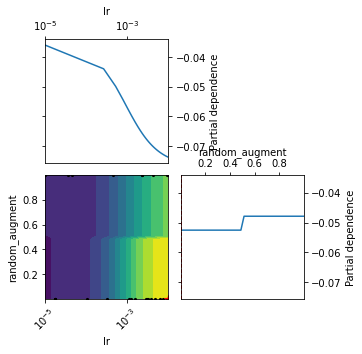

In [ ]:
skopt.plots.plot_objective(skopt_results)
for i, hyperparam in enumerate(HYPERPARAM_SPACE):
    print(f"{hyperparam.name:20} {skopt_results.x[i]}")

In [ ]:
averaged_over_support = test_handler.results.groupby([col for col in test_handler.results.columns if col not in ["n_support", "accuracy", "accuracy_std"]], as_index=False, dropna=False).mean()

# Drop any sets which didn't complete the full list of support values (if interrupted, etc)
averaged_over_support = averaged_over_support[averaged_over_support["n_support"] == np.mean(N_SUPPORT_LIST)]

for hyperparam in HYPERPARAM_SPACE:
    plt.scatter(averaged_over_support[f"classifier.{hyperparam.name}"].values, averaged_over_support["accuracy"].values)
    plt.ylabel("accuracy")
    plt.xlabel(hyperparam.name)
    plt.title(hyperparam.name)
    plt.show()

NameError: name 'N_SUPPORT_LIST' is not defined